In [1]:
!pip install -q pytorch-lightning pytorch-forecasting xgboost numdifftools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [267]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
from torch.autograd import Variable

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
import numdifftools as nd
from scipy.signal import argrelextrema
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import ADASYN

In [268]:
df=pd.read_csv("/content/drive/MyDrive/tft/data/old/df_pca_n.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,close
0,-4.728898,-1.115874,-0.350434,0.465851,0.346966,-0.063788,-0.840479,-0.644939,0.120015,1.910322,1.305534,0.669070,0.307071,1.389222,1.563639,0.564337,0.155247,28212.73
1,-4.635488,-2.741018,1.690103,-2.328273,-0.770616,1.601905,0.038216,-1.187851,1.623920,0.795812,-1.426525,1.030457,0.065907,1.300028,1.824407,-0.132587,0.037102,28127.82
2,-4.694583,-1.193204,0.440777,1.554080,0.044771,0.620009,0.986779,0.868953,1.621704,-0.432284,0.463382,0.740617,0.691632,1.340005,1.675177,0.299795,0.201588,28169.00
3,-4.708888,-2.340780,0.054083,-0.864007,0.050861,-0.809183,-2.061673,0.437444,1.108165,0.823587,0.540933,0.793279,0.287486,1.366688,1.618464,0.438763,0.133583,28128.59
4,-4.715028,-1.494159,0.141522,1.021576,0.024130,0.061481,0.593962,-0.776617,1.957156,0.502589,1.086233,0.736398,0.540106,1.357617,1.638440,0.410520,0.196583,28150.00


In [269]:
print(df.shape)

(210485, 18)


In [270]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

print(NaNCheck(df))

Series([], dtype: int64)


In [271]:
def sliding_window(x, y, y_raw, idx, feature_window,label_window,trend_window):
    x_ = []
    y_ = []
    y_tft_pr = []
    y_tft_cl = []
    y_tft_tr = []
    low_idx  = []
    backward_length = max(trend_window,label_window)
    for i in range(backward_length, x.shape[0]-label_window):
        tmp_x = x[i - feature_window: i, :]
        tmp_y = y[i]
        tmp_y_tft_pr = y[i - feature_window: i + 1]
        tmp_y_tft_cl = y_raw[i - label_window: i + label_window+1]
        tmp_y_tft_tr = y_raw[i - trend_window: i, :]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_tft_pr.append(tmp_y_tft_pr)
        y_tft_cl.append(tmp_y_tft_cl)
        y_tft_tr.append(tmp_y_tft_tr)
        low_idx.append(idx[i - feature_window])
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_tft_pr = torch.from_numpy(np.array(y_tft_pr)).float()
    y_tft_cl = torch.from_numpy(np.array(y_tft_cl)).float()
    y_tft_tr = torch.from_numpy(np.array(y_tft_tr)).float()
    return x_, y_, y_tft_pr,y_tft_cl,y_tft_tr,low_idx


In [272]:
def trend_detection(data):
    n = data.shape[1]
    sets = data.shape[0]
    mean_derivatives = np.zeros((sets,1))

    data = data.numpy()

    for i in range(sets):
        # Select the i-th 20 set
        x = np.arange(1,n+1)
        x_fake = np.arange(1.1, n, 0.1)
        y = data[i, :, 0]
        # Simple interpolation of x and y
        f = interp1d(x, y)

        # derivative of y with respect to x
        df_dx = nd.Derivative(f, step=1e-6)(x_fake)
        # Calculate the mean derivative for the i-th 20 set
        average = np.average(df_dx)
        mean_derivatives[i][0] = average
    return  torch.from_numpy(mean_derivatives)

In [273]:
# --------------------------------------
# Constants / Hyperparameters
# --------------------------------------
FEATURE_WINDOW = 32          # sliding window length
LABEL_WINDOW = 5             # lookahead for bottom detection
TREND_WINDOW = 12          # trend measurement length
BATCH_SIZE = 64
MAX_EPOCHS = 30

training_duration = 4032
validation_duration = 864
testing_duration = 8640
train_offset = 8640*4+4032
smoothing_threshold = 10
sliding_window_size = 10
classification_label_size = 12
trend_measure_lenth = 12
base_folder         = "/content/drive/MyDrive/tft/"
model_save_folder   = base_folder + "models-10"  # folder to save checkpoints

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [274]:
labels_df = df["close"]
features_df = df.drop(columns=["close"])

st_train = train_offset
train_idx = df.index[st_train:st_train+training_duration]
train_x = features_df.iloc[st_train:st_train+training_duration].values
train_y = labels_df.iloc[st_train:st_train+training_duration]

# st_test = training_duration+validation_duration+st_train
st_test = 864
test_idx = df.index[st_test:st_test+testing_duration]
test_x = features_df.iloc[st_test:st_test+testing_duration].values
test_y = labels_df.iloc[st_test:st_test+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (4032, 17) trainY: (4032,)
testX: (8640, 17) testY: (8640,)


In [275]:
raw_train_y = train_y.values.reshape(-1, 1)
raw_test_y = test_y.values.reshape(-1, 1)

In [276]:
trend_scaler = MinMaxScaler(feature_range = (0, 1))

# For price prediction model
train_x_slide, train_y_slide, train_y_tft,train_y_tft_cl,train_direction_slide, train_idx = sliding_window(train_x, raw_train_y,raw_train_y, train_idx, sliding_window_size,classification_label_size,trend_measure_lenth)
test_x_slide, test_y_slide, test_y_tft,test_y_tft_cl,test_direction_slide, test_idx = sliding_window(test_x, raw_test_y, raw_test_y, test_idx, sliding_window_size,classification_label_size,trend_measure_lenth)

train_trend_features = trend_detection(train_direction_slide)
test_trend_features = trend_detection(test_direction_slide)
print(f"train_trend_features: {train_trend_features.shape}")
train_trend_features = torch.tensor(trend_scaler.fit_transform(train_trend_features))
test_trend_features = torch.tensor(trend_scaler.transform(test_trend_features))
new_feature_tensor_train = train_trend_features.repeat(1,10)
print(f"new_feature_tensor_train 1: {new_feature_tensor_train.shape}")
new_feature_tensor_train = new_feature_tensor_train.unsqueeze(2)
print(f"new_feature_tensor_train 2: {new_feature_tensor_train.shape}")
new_feature_tensor_test = test_trend_features.repeat(1,10)
new_feature_tensor_test = new_feature_tensor_test.unsqueeze(2)

print('For Price prediction')
print(f'train_x_slide: {train_x_slide.shape} train_y_slide: {train_y_slide.shape} train_y_gan: {train_y_tft.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_slide: {test_y_slide.shape} test_y_gan: {test_y_tft.shape}\n')

print('For Bottom classification')
print(f'train_x_slide: {train_x_slide.shape} train_y_gan_cl: {train_y_tft_cl.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_gan_cl: {test_y_tft_cl.shape}\n')

print('For current trend calculation')
print(f'train_direction_slide: {train_direction_slide.shape} train_trend_features: {train_trend_features.shape} ')
print(f'test_direction_slide: {test_direction_slide.shape} test_trend_features: {test_trend_features.shape} ')

train_trend_features: torch.Size([4008, 1])
new_feature_tensor_train 1: torch.Size([4008, 10])
new_feature_tensor_train 2: torch.Size([4008, 10, 1])
For Price prediction
train_x_slide: torch.Size([4008, 10, 17]) train_y_slide: torch.Size([4008, 1]) train_y_gan: torch.Size([4008, 11, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_slide: torch.Size([8616, 1]) test_y_gan: torch.Size([8616, 11, 1])

For Bottom classification
train_x_slide: torch.Size([4008, 10, 17]) train_y_gan_cl: torch.Size([4008, 25, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_gan_cl: torch.Size([8616, 25, 1])

For current trend calculation
train_direction_slide: torch.Size([4008, 12, 1]) train_trend_features: torch.Size([4008, 1]) 
test_direction_slide: torch.Size([8616, 12, 1]) test_trend_features: torch.Size([8616, 1]) 


In [277]:
def find_bottom_point_labels_mean(y,slide):

    y1 = y[:, :slide, :] # 128,10,1
    y2 = y[:, slide+1:, :]
    values = y[:,slide,:]

    y_avg = torch.mean(y1,dim=1)
    y_next_avg = torch.mean(y2, dim=1)
    y_bool = y_avg>(y[:,slide,:] + smoothing_threshold)
    y_next_bool = y_next_avg>(y[:,slide,:] + smoothing_threshold)
    result = np.logical_and(y_bool.numpy(), y_next_bool.numpy())
    y_label=np.where(result, 1, 0)

    index_val = np.where(y_label == 1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(15, 8))
    plt.plot(y[:,slide,:], zorder=0)
    plt.scatter(index_val[0], values[np.where(y_label == 1)],
      label='Minima', s=100, color=colors[1], marker='^')
    plt.legend()
    plt.show()

    y_labels = torch.from_numpy(y_label)

    return y_labels

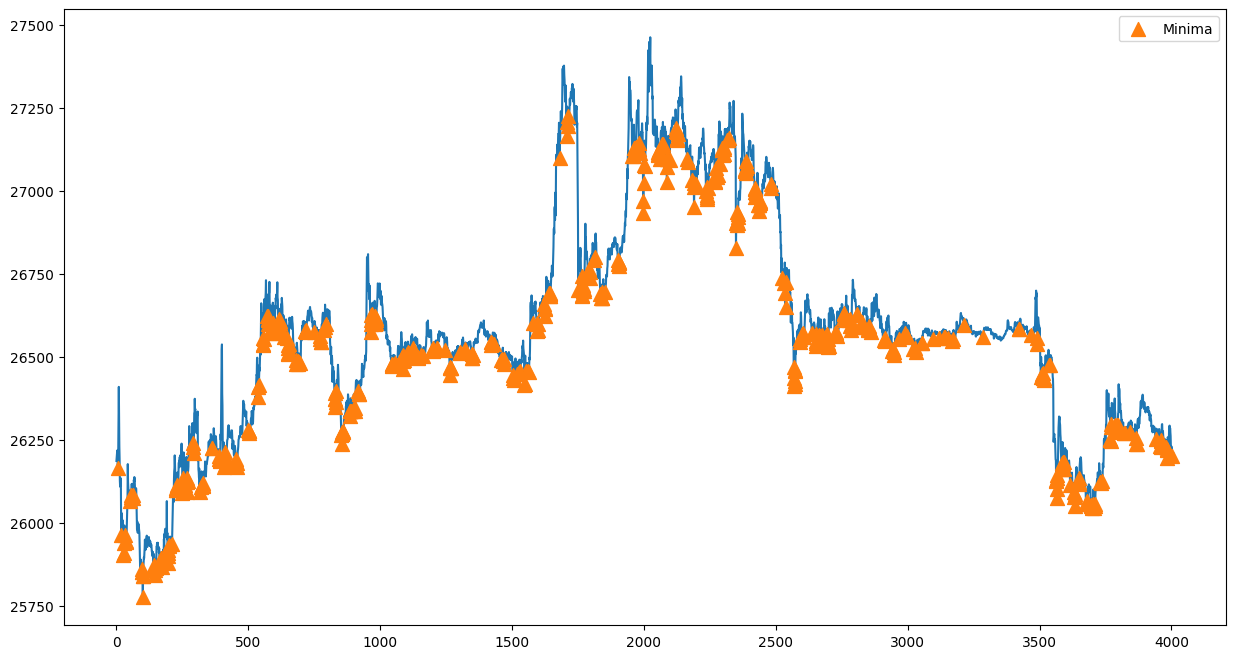

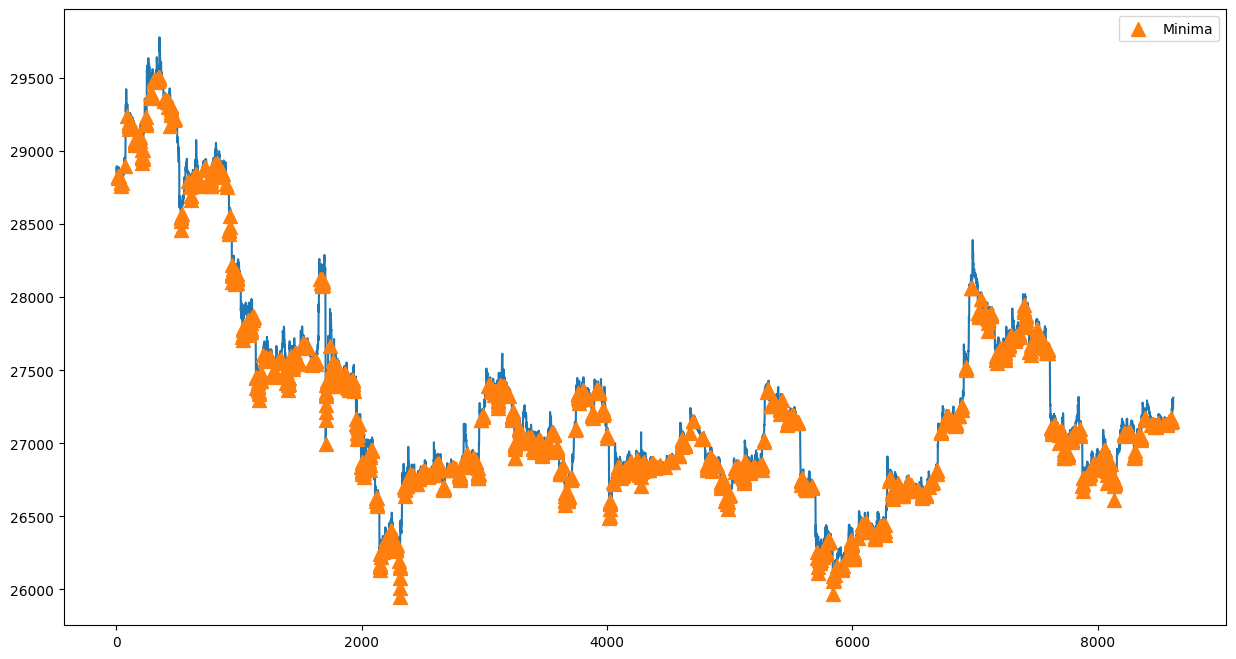

[3439  569]
[7171 1445]
6.043936731107205


In [278]:
def calc_labels(labels):
    unique_labels = torch.unique(labels)
    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    return label_counts

train_bottoms = find_bottom_point_labels_mean(train_y_tft_cl,classification_label_size)
test_bottoms = find_bottom_point_labels_mean(test_y_tft_cl,classification_label_size)
train_bottom_count = calc_labels(train_bottoms)
test_bottom_count = calc_labels(test_bottoms)
print(train_bottom_count)
print(test_bottom_count)
print(train_bottom_count[0]/train_bottom_count[1])

In [279]:
train_bottoms.size()

torch.Size([4008, 1])

In [280]:
def load_tft_strict_cpu(checkpoint_path: str) -> TemporalFusionTransformer:
    """
    Load a TFT Lightning checkpoint strictly on CPU.
    Avoids any .cpu() calls that trigger torchmetrics CUDA init.
    """
    # 1) Load full checkpoint (allow unpickle) onto CPU
    ckpt = torch.load(
        checkpoint_path,
        map_location=torch.device("cpu"),
        weights_only=False
    )
    # 2) Extract Lightning hyperparameters
    hparams = ckpt.get("hyper_parameters", ckpt.get("hparams", {}))
    # 3) Instantiate fresh TFT on CPU (no GPUs involved)
    model = TemporalFusionTransformer(**hparams)
    # 4) Load weights & buffers (already on CPU)
    model.load_state_dict(ckpt["state_dict"])
    # 5) Patch every torchmetrics.Metric to live on CPU
    for module in model.modules():
        if isinstance(module, torchmetrics.Metric):
            module._device = torch.device("cpu")
    # 6) Set to inference mode (no further .cpu needed)
    model.eval()
    return model

In [281]:
train_x_slide.size()

torch.Size([4008, 10, 17])

In [282]:
for el in train_x_slide:
  print(el.size())

torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([1

In [283]:
from pytorch_forecasting.data import GroupNormalizer
total_size          = 20000
train_df = df.iloc[:total_size].copy()
train_df["time_idx"] = train_df.index
train_df["series"]   = "BTC"
target_normalizer = GroupNormalizer(
    groups=["series"],
    transformation="log",       # learn in log space, invert with exp
    )
pca_columns = [c for c in df.columns if c.startswith("pca")]
train_dataset = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target="close",
        group_ids=["series"],
        min_encoder_length=sliding_window_size,
        max_encoder_length=sliding_window_size,
        min_prediction_length=1,
        max_prediction_length=1,
        static_categoricals=["series"],
        time_varying_known_reals=["time_idx"] + pca_columns,
        time_varying_unknown_reals=["close"],
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )
def load_inference_dataset(
    input_array: np.ndarray,
    close_array: np.ndarray,
    pca_columns: list,
    look_back: int,
    prediction_length: int,
    id: int,
    series_id: str = "BTC"
):
    """
    Create a TimeSeriesDataSet for inference from a raw input array.

    Args:
        input_array: np.ndarray of shape (1, look_back, num_features)
        pca_columns: list of feature names corresponding to the last dim of input_array
        look_back: encoder length
        prediction_length: decoder length (forecast horizon)
        series_id: identifier for the time series (group id)

    Returns:
        TimeSeriesDataSet suitable for model inference
    """
    # build a flat DataFrame with one row per time step
    batch, seq_len, num_features = input_array.shape
    assert batch == 1, "Batch size >1 not supported for this helper"
    assert seq_len == look_back, f"Expected look_back={look_back}, but got sequence length={seq_len}"
    records = []
    for t in range(look_back):
        # input_array shape: (1, look_back, num_features)
        record = {col: float(input_array[0, t, i]) for i, col in enumerate(pca_columns)}
        record["time_idx"] = int(t)
        record["series"] = series_id
        record["close"] = float(close_array[0, t])
        records.append(record)

    for t in range(look_back, look_back + prediction_length):
        record = {col: 0.0 for col in pca_columns}   # or carry-forward/mean if you prefer
        record["time_idx"] = int(t)
        record["series"]   = series_id
        record["close"]    = 0.0
        records.append(record)

    dfx = pd.DataFrame.from_records(records)
    row_slice = slice(id, id + look_back + prediction_length)
    chunkx = df[row_slice]
    chunkx["time_idx"] = chunkx.index
    chunkx["series"]   = "BTC"
    return dfx, TimeSeriesDataSet(
        dfx,
        time_idx="time_idx",
        target="close",
        group_ids=["series"],
        min_encoder_length=look_back,
        max_encoder_length=look_back,
        min_prediction_length=prediction_length,
        max_prediction_length=prediction_length,
        static_categoricals=["series"],
        time_varying_known_reals=["time_idx"] + pca_columns,
        time_varying_unknown_reals=["close"],
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    ), TimeSeriesDataSet.from_dataset(
    train_dataset,
    chunkx,
    predict=False,
    stop_randomization=True
), chunkx

In [284]:
def infer_attention(
    model_checkpoint: str,
    input_array: np.ndarray,
    close_array: np.ndarray,           # shape (1, look_back)
    pca_columns: list,
    look_back: int,
    prediction_length: int,
    id: int,
    series_id: str = "BTC",
) -> tuple:
    """
    Load a trained TFT from checkpoint and infer encoder & decoder attention weights for a single sample.

    Args:
        model_checkpoint: path to the .ckpt file saved from a trained TFT
        input_array: np.ndarray of shape (1, num_features, look_back)
        pca_columns: list of names for the features in input_array
        look_back: number of time steps provided to the encoder
        prediction_length: number of time steps to forecast
        series_id: identifier for the time series (matches training)

    Returns:
        encoder_attention: torch.Tensor of shape (attention_heads, look_back, look_back)
        decoder_attention: torch.Tensor of shape (attention_heads, decoder_length, look_back)
    """
    # load model on CPU
    model = load_tft_strict_cpu(model_checkpoint)
    # prepare dataset & dataloader
    dfxx, inference_new_dataset, inference_dataset, chunkx = load_inference_dataset(
        input_array, close_array, pca_columns, look_back, prediction_length, id, series_id
    )
    dataloader = inference_dataset.to_dataloader(
        train=False, batch_size=1, num_workers=0
    )
    # 3) set up hooks to grab:
    #    - encoder_output from the LSTM encoder (pre-attention)
    #    - post-LSTM output after gated-residual + layernorm
    encoder_lstm_outputs = []
    post_lstm_outputs    = []
    def lstm_enc_hook(module, inp, out):
        # out is (encoder_output, (h_n, c_n))
        encoder_lstm_outputs.append(out[0].detach())
    def post_lstm_hook(module, inp, out):
        # out is the gated+normalized tensor
        post_lstm_outputs.append(out.detach())

    model.lstm_encoder.register_forward_hook(lstm_enc_hook)
    model.post_lstm_add_norm_encoder.register_forward_hook(post_lstm_hook)

    raw_output = model.predict(dataloader, mode="raw")
    # inference and extract raw attention
    encoder_attention = raw_output["encoder_attention"][0].cpu()
    decoder_attention = raw_output["decoder_attention"][0].cpu()
    prediction        = raw_output["prediction"][0].cpu()

    # hooked lists each have one entry of shape [1, look_back, hidden_size]
    enc_lstm_seq  = encoder_lstm_outputs[0].cpu()[0]  # → [look_back, hidden_size]
    post_lstm_seq = post_lstm_outputs[0].cpu()[0]     # → [look_back, hidden_size]

    return encoder_attention, decoder_attention, prediction, enc_lstm_seq, post_lstm_seq, dfxx, chunkx


In [285]:
def infer_attention_batch(
    model: TemporalFusionTransformer,
    look_back: int,
    prediction_length: int,
    df: pd.DataFrame,
):
    dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df,
    predict=False,
    stop_randomization=True
)
    dl = dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

    enc_lstm_list = []
    post_lstm_enc_list = []

    def lstm_enc_hook(module, inp, out):
        enc_lstm_list.append(out[0].detach())          # [B, enc_len, H]

    def post_lstm_hook(module, inp, out):
        # Keep only encoder-length outputs
        if out.size(1) == look_back:
            post_lstm_enc_list.append(out.detach())    # [B, enc_len, H]

    h1 = model.lstm_encoder.register_forward_hook(lstm_enc_hook)
    h2 = model.post_lstm_add_norm_encoder.register_forward_hook(post_lstm_hook)

    try:
        raw = model.predict(dl, mode="raw")
    finally:
        h1.remove(); h2.remove()

    encoder_attention = raw["encoder_attention"].cpu()
    decoder_attention = raw["decoder_attention"].cpu()
    prediction        = raw["prediction"].cpu()

    enc_lstm_seq  = torch.cat(enc_lstm_list, dim=0).cpu()          # [N, enc_len, H]
    post_lstm_seq = torch.cat(post_lstm_enc_list, dim=0).cpu()     # aligned shapes

    return encoder_attention, decoder_attention, prediction, enc_lstm_seq, post_lstm_seq


In [286]:
# import torchmetrics

# pca_columns = [c for c in df.columns if c.startswith("pca")]
# ckpt_path = "/content/drive/MyDrive/tft/model-10-1-20.0K/best_tft.ckpt"
# count = 0
# weight_list = []
# pred_ind_list = []
# df_ex = None
# df_chunkx = None
# for el, close11, tr_idx in zip(train_x_slide, train_y_tft, train_idx):
#     # el.size() is torch.Size([10,17])
#     closes = close11.squeeze(-1).numpy()         # (look_back+1,)
#     close_enc = closes[:-1][None, :]             # (1, look_back)
#     close_true = closes[-1]                      # scalar, the true 11th value
#     # finally add a batch-dim → (1,10)
#     el_batched = el.unsqueeze(0)          # now torch.Size([1,10,17])
#     print(tr_idx)
#     enc_attn, dec_attn, pred, enc_lstm_seq, post_lstm_seq, dfxxx, dfxxxx = infer_attention(
#         ckpt_path,
#         el_batched.numpy(),                # shape (1, look_back, num_features)
#         close_enc,
#         pca_columns,
#         sliding_window_size,
#         1,
#         tr_idx
#     )
#     weight_list.append(post_lstm_seq)
#     pred_ind_list.append(pred)
#     # print(f"Encoder attention shape: {enc_attn}")
#     # print(f"Decoder attention shape: {dec_attn}")
#     print(pred)
#     # print(f"Predicted: {forecast:.2f}, Actual: {close_true:.2f}")
#     # print(f"post_lstm_seq:{post_lstm_seq}")
#     # print(f"enc_lstm_seq:{enc_lstm_seq}")
#     if count==0:
#         df_ex =dfxxx
#         df_chunkx = dfxxxx
#     count += 1
#     if count%10==0:
#         print(f"#############{count}")
# print(f"Loaded model from {ckpt_path}")
# weight_list = torch.from_numpy(np.array(weight_list)).float()
# print(weight_list)

In [287]:
model = load_tft_strict_cpu(ckpt_path)
lower_idx = min(train_idx)
upper_idx = max(train_idx) + sliding_window_size + 1
row_slice = slice(lower_idx, upper_idx)
chunk = df[row_slice]
chunk["time_idx"] = chunk.index
chunk["series"]   = "BTC"

In [288]:
lower_idx

38594

In [289]:
upper_idx

42612

In [290]:
chunk

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,close,time_idx,series
38594,-6.995763,0.012713,0.648827,0.920585,0.402752,-0.706221,-1.036563,1.058866,-0.500723,1.053679,-0.309984,-0.267060,0.580608,-1.077256,-0.080612,-0.195460,-0.449507,26114.39,38594,BTC
38595,-6.956592,1.318799,1.568979,2.029470,0.022201,0.332573,-1.722112,0.693449,0.067039,0.631200,0.321364,-0.680037,0.400087,-1.107187,0.041251,-0.519404,-0.234972,26182.25,38595,BTC
38596,-7.008358,0.101972,0.272669,-0.860404,0.636614,-0.169286,-0.393496,0.366410,-0.974171,-1.422761,0.940727,-0.686009,-0.092630,-1.037112,-0.129343,-0.069762,-0.280450,26159.98,38596,BTC
38597,-7.026927,-0.316705,-0.130379,-0.956880,0.767986,1.831297,-1.517240,-1.278625,0.649020,0.699187,-0.018410,-0.441442,0.033140,-1.030637,-0.183133,0.071821,-0.338593,26132.52,38597,BTC
38598,-7.038834,0.464786,-0.101321,0.591382,0.848660,0.094928,0.539461,-0.052152,-0.168792,-0.549051,-0.290044,-0.405532,0.188470,-1.029807,-0.179159,0.054015,-0.350843,26153.13,38598,BTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42607,-7.159537,-1.241639,-0.267543,0.057711,0.151219,-0.022553,1.080148,-0.779184,-1.354209,0.108795,0.704772,0.596820,0.355233,-1.167117,-0.064817,0.106799,0.064529,26213.19,42607,BTC
42608,-7.162434,-1.544444,-0.333900,-0.106991,0.120642,-1.786445,0.063864,0.389105,1.303254,1.540374,1.630667,0.843326,0.372010,-1.174771,-0.078594,0.132314,-0.003111,26201.55,42608,BTC
42609,-7.160675,-1.366394,-0.216773,0.318468,0.128617,0.704664,0.550244,2.109257,-0.149391,0.414551,-0.136638,0.757394,0.458932,-1.162071,-0.056341,0.083778,0.047920,26204.00,42609,BTC
42610,-7.163528,-1.552750,-0.185348,0.083647,0.069017,0.005764,-0.050689,0.865145,0.464759,-0.179619,0.371216,0.837987,0.448648,-1.179718,-0.049580,0.062247,0.014673,26198.96,42610,BTC


In [291]:
enc_attn, dec_attn, pred_1, enc_lstm_seq, post_lstm_seq = infer_attention_batch(
        model,
        10,                # shape (1, look_back, num_features)
        1,
        chunk
    )

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [292]:
post_lstm_seq.size()

torch.Size([4008, 10, 32])

In [293]:
post_lstm_seq[0]

tensor([[-0.9545,  0.2260, -0.3924, -0.0476, -0.2434, -0.4807, -0.0910,  0.0349,
         -0.4834, -1.5860, -1.1360, -0.8365, -0.5117,  0.1989, -0.0733, -0.1014,
          1.1105, -0.5888,  0.1687, -0.0358,  0.0625, -0.1237, -0.0473, -1.6861,
         -0.1964, -0.1355, -0.1768,  0.0232,  5.4424,  5.9971,  0.5153, -0.3600],
        [-0.9600,  0.0792, -0.4341, -0.0429, -0.1791, -0.4497, -0.0795, -0.0323,
         -0.4435, -1.8170, -1.1741, -0.7948, -0.2469,  0.2590, -0.0660, -0.0648,
          3.4806, -0.7768,  0.2203, -0.0211,  0.0861, -0.1080, -0.0402, -2.0002,
         -0.2643, -0.1568, -0.1435,  0.0404,  4.8073,  5.6961,  0.4903, -0.5202],
        [-0.9605,  0.0781, -0.4355, -0.0445, -0.1851, -0.4537, -0.0827, -0.0378,
         -0.4565, -1.8270, -1.1624, -0.7551, -0.1784,  0.2576, -0.0685, -0.0666,
          3.4774, -0.7324,  0.2238, -0.0224,  0.0886, -0.1082, -0.0430, -2.0184,
         -0.2643, -0.1595, -0.1476,  0.0397,  4.7930,  5.6816,  0.4883, -0.5115],
        [-0.9676,  0.0829

In [294]:
pred_1

tensor([[[26129.4512, 26179.7852, 26191.6484]],

        [[26133.2891, 26182.0566, 26196.8926]],

        [[26139.8184, 26189.4746, 26205.1387]],

        ...,

        [[26129.6250, 26185.8789, 26203.2402]],

        [[26127.0840, 26182.7324, 26198.7168]],

        [[26135.2070, 26190.8223, 26208.7637]]])

In [295]:
pred_ind_list

[tensor([[26129.4512, 26179.7852, 26191.6484]]),
 tensor([[26133.2891, 26182.0566, 26196.8926]]),
 tensor([[26139.8184, 26189.4746, 26205.1387]]),
 tensor([[26150.3652, 26199.9668, 26216.1621]]),
 tensor([[26134.7578, 26186.8027, 26200.6152]]),
 tensor([[26100.5605, 26151.8613, 26165.5586]]),
 tensor([[26115.3008, 26163.8359, 26178.4863]]),
 tensor([[26176.5391, 26223.2148, 26238.8730]]),
 tensor([[26261.7051, 26305.2188, 26323.7910]]),
 tensor([[26372.0605, 26429.0625, 26463.2109]]),
 tensor([[26273.4043, 26324.4922, 26335.0391]]),
 tensor([[26180.2598, 26234.9199, 26250.0371]]),
 tensor([[26142.6113, 26196.3945, 26212.6875]]),
 tensor([[26086.2773, 26137.6992, 26148.7207]]),
 tensor([[26054.8750, 26115.3750, 26136.8281]]),
 tensor([[26069.0664, 26119.3105, 26134.1855]])]